In [92]:
#%matplotlib qt

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from pathlib import Path
import supervision as sv

### Punto 1

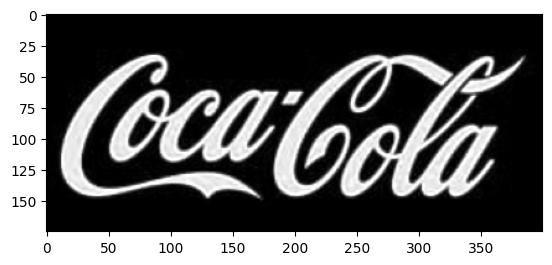

In [93]:
img1 = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('images/coca_logo_2.png', cv.IMREAD_GRAYSCALE)
img1_inverted = cv.bitwise_not(img1)
img1_enhanced = cv.convertScaleAbs(img1_inverted, alpha=1.7, beta=30)
plt.imshow(img1_enhanced, cmap='gray')


In [94]:
def detectar_logo(img_template, img_search):
    """
    Detecta un logo usando SIFT → FLANN → Homografía
    Con reintentos aplicando bitwise_not si la primera detección falla
    
    Parámetros:
        img_template: imagen del patrón/logo (ya procesada)
        img_search: imagen donde buscar el logo (ya procesada)
    
    Retorna:
        resultado: diccionario con detección o None si falla
    """
    
    sift = cv.SIFT_create()
    intentos = [
        ("original", img_search),
        ("invertida", cv.bitwise_not(img_search))
    ]
    
    for intento_nombre, img_actual in intentos:
        
        # SIFT
        kp1, des1 = sift.detectAndCompute(img_template, None)
        kp2, des2 = sift.detectAndCompute(img_actual, None)
        
        print(f"Keypoints template: {len(kp1)}")
        print(f"Keypoints search ({intento_nombre}): {len(kp2)}")
        
        if des1 is None or des2 is None:
            print(f"Descriptores insuficientes ({intento_nombre})")
            continue
        
        # FLANN
        FLANN_INDEX_KDTREE = 1
        flann = cv.FlannBasedMatcher(
            dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
            dict(checks=50)
        )
        matches = flann.knnMatch(des1, des2, k=2)
        good = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.7 * n.distance:
                    good.append(m)
        
        print(f"Matches buenos: {len(good)}")
        
        # Homografía 
        MIN_MATCH_COUNT = 8
        if len(good) < MIN_MATCH_COUNT:
            print(f"Matches insuficientes ({intento_nombre})")
            continue
        
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        
        if M is None:
            print(f"Homografía no válida ({intento_nombre})")
            continue
        
        # Esquinas transformadas
        h, w = img_template.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
        
        inliers = sum(mask.ravel())
        print(f"Inliers: {inliers}/{len(good)}")
        print(f"Detección exitosa ({intento_nombre})")
        
        return {
            'keypoints1': kp1,
            'keypoints2': kp2,
            'matches': good,
            'mask': mask,
            'puntos_esquina': dst,
            'homografia': M,
            'intento': intento_nombre
        }
    
    print("\nNo se pudo detectar el logo en ningún intento")
    return None



Procesando: COCA-COLA-LOGO.jpg
Keypoints template: 172
Keypoints search (original): 2848
Matches buenos: 37
Inliers: 21/37
Detección exitosa (original)

Procesando: coca_logo_1.png
Keypoints template: 172
Keypoints search (original): 289
Matches buenos: 37
Inliers: 31/37
Detección exitosa (original)

Procesando: coca_logo_2.png
Keypoints template: 172
Keypoints search (original): 615
Matches buenos: 34
Inliers: 26/34
Detección exitosa (original)

Procesando: coca_multi.png
Keypoints template: 172
Keypoints search (original): 4046
Matches buenos: 3
Matches insuficientes (original)
Keypoints template: 172
Keypoints search (invertida): 4048
Matches buenos: 1
Matches insuficientes (invertida)

No se pudo detectar el logo en ningún intento
No se detectó logo en coca_multi.png


Procesando: coca_retro_1.png
Keypoints template: 172
Keypoints search (original): 3892
Matches buenos: 2
Matches insuficientes (original)
Keypoints template: 172
Keypoints search (invertida): 3894
Matches buenos: 28

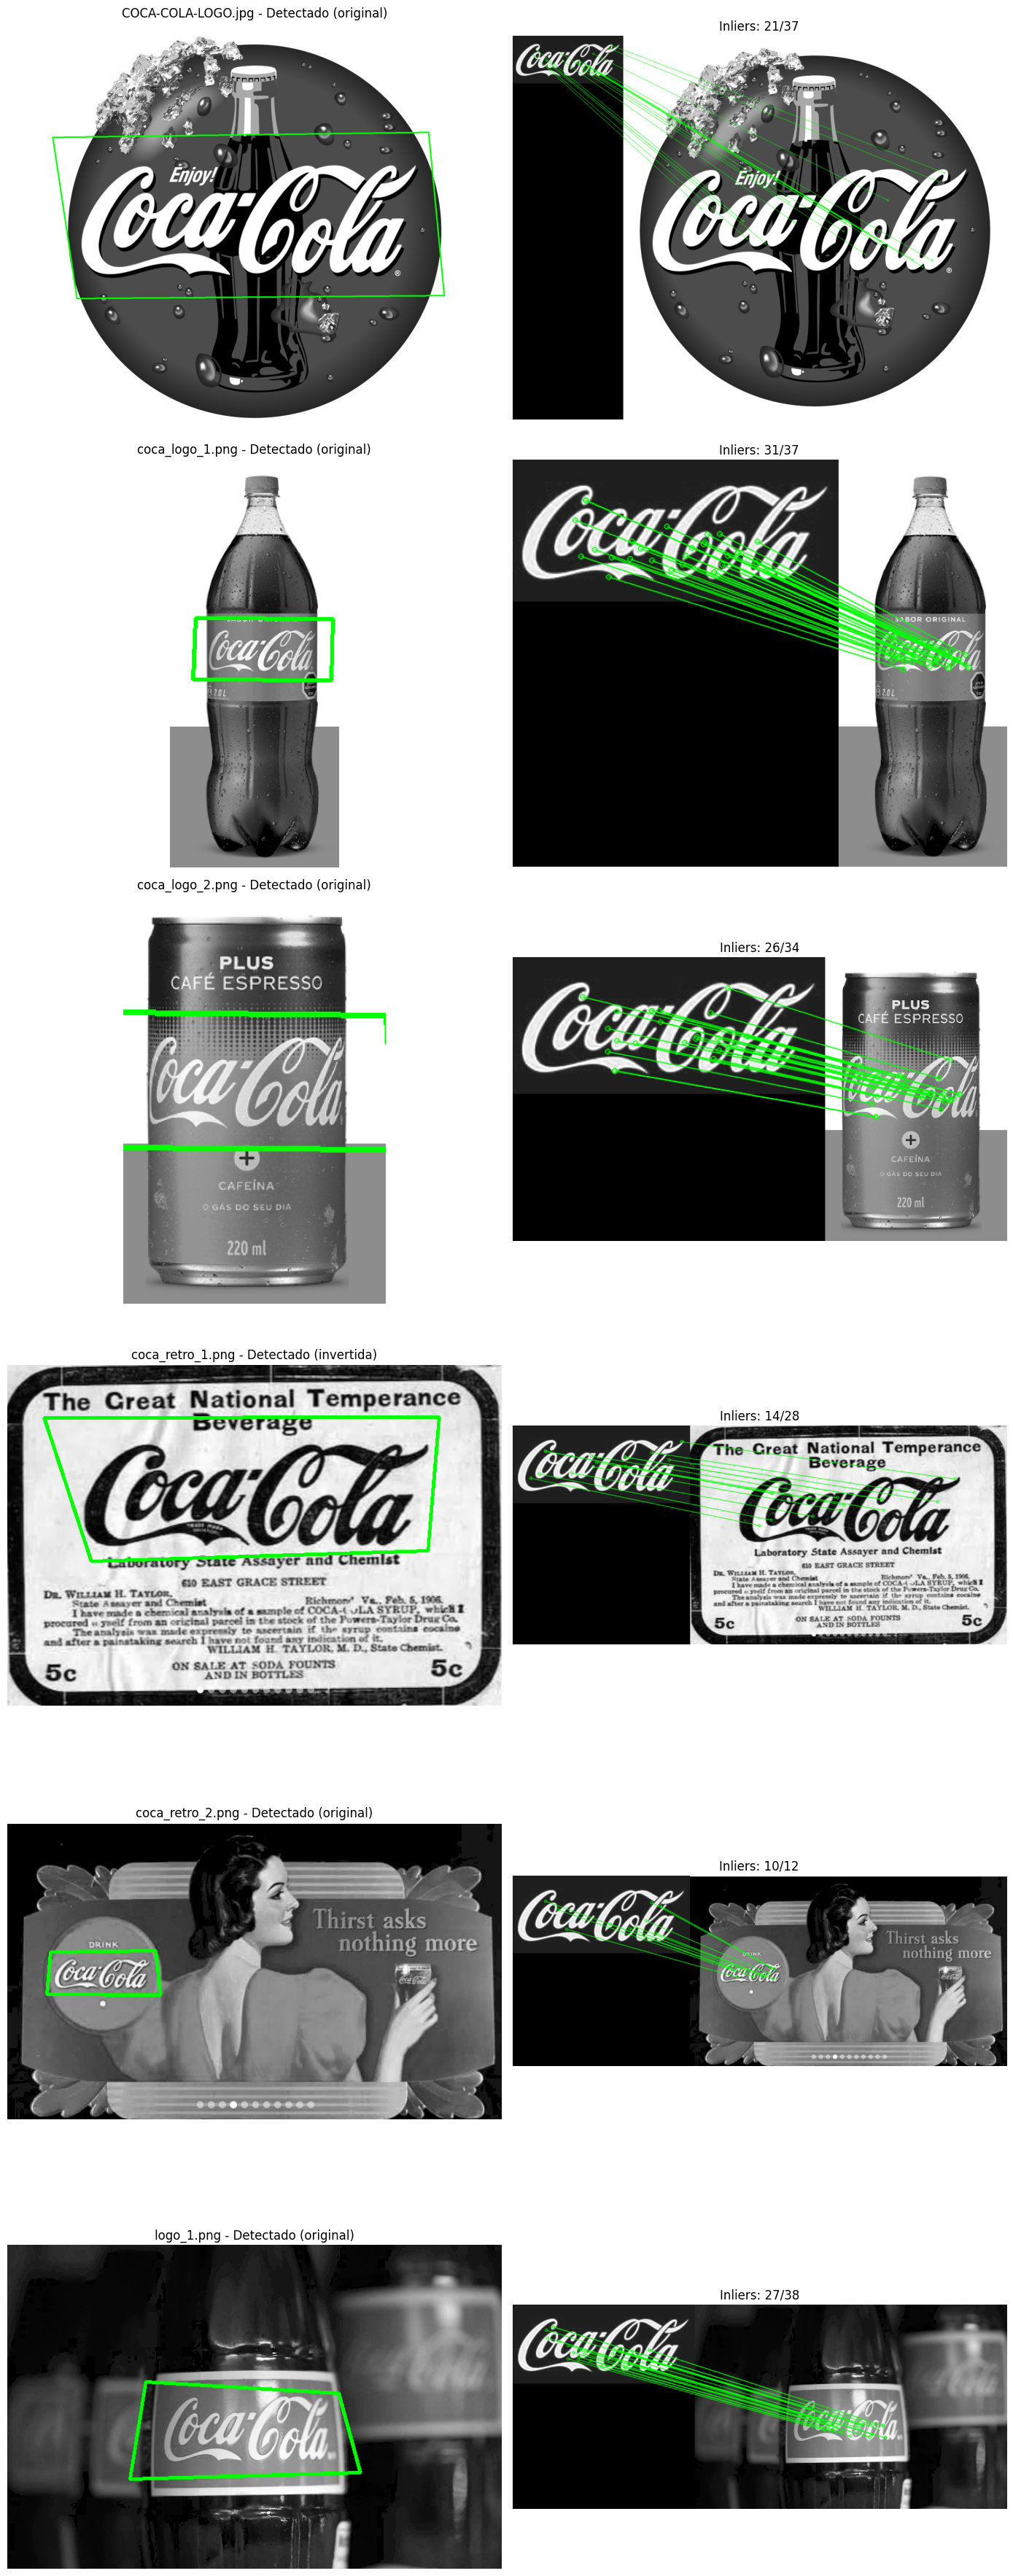

In [95]:

img_template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
img_template = cv.bitwise_not(img_template)
img_template = cv.convertScaleAbs(img_template, alpha=1.7, beta=30)

images_dir = 'images'
image_extensions = {'.png', '.jpg', '.jpeg'}
resultados = []

for filename in sorted(os.listdir(images_dir)):
    if Path(filename).suffix.lower() not in image_extensions:
        continue
    
    img_path = os.path.join(images_dir, filename)
    img_search = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    

    
    print(f"\nProcesando: {filename}")

    
    # Detectar logo
    resultado = detectar_logo(img_template, img_search)
    
    if resultado:
        resultado['filename'] = filename
        resultado['imagen_original'] = img_search
        resultados.append(resultado)
    else:
        print(f"No se detectó logo en {filename}\n")


print(f"RESULTADOS: {len(resultados)}/{len([f for f in os.listdir(images_dir) if Path(f).suffix.lower() in image_extensions])} imágenes procesadas")



fig, axes = plt.subplots(len(resultados), 2, figsize=(14, 6 * len(resultados)))

if len(resultados) == 1:
    axes = axes.reshape(1, -1)

for idx, resultado in enumerate(resultados):

    img_search_color = cv.cvtColor(resultado['imagen_original'], cv.COLOR_GRAY2BGR)
    img_marked = cv.polylines(
        img_search_color.copy(),
        [np.int32(resultado['puntos_esquina'])],
        True, (0, 255, 0), 3
    )
    axes[idx, 0].imshow(cv.cvtColor(img_marked, cv.COLOR_BGR2RGB))
    axes[idx, 0].set_title(f"{resultado['filename']} - Detectado ({resultado['intento']})")
    axes[idx, 0].axis('off')
    
    # Derecha: Matches
    draw_params = dict(
        matchColor=(0, 255, 0),
        singlePointColor=None,
        matchesMask=resultado['mask'].ravel().tolist(),
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    img_matches = cv.drawMatches(
        img_template, resultado['keypoints1'],
        resultado['imagen_original'], resultado['keypoints2'],
        resultado['matches'], None, **draw_params
    )
    axes[idx, 1].imshow(img_matches)
    inliers = sum(resultado['mask'].ravel().tolist())
    axes[idx, 1].set_title(f"Inliers: {inliers}/{len(resultado['matches'])}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()


### Punto 2

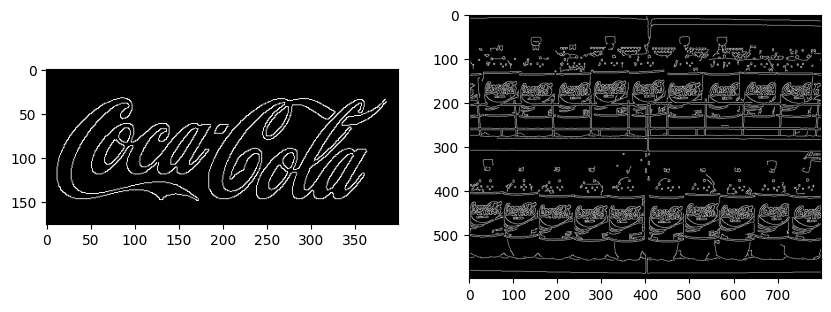

In [96]:
# Cargamos la imagen a procesar
img = cv.imread('images/coca_multi.png')
template = cv.imread('template/pattern.png')

img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)

img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

#template_inverted = cv.bitwise_not(template_gray)
#img_gray_blurred = cv.medianBlur(img_gray,5)

img_gb = cv.GaussianBlur(img_gray,(5,5),0)

template_canny = cv.Canny(template_gray, 50, 200)
img_gray_canny = cv.Canny(img_gb, 25 , 200)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(template_canny,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_gray_canny,cmap='gray')

In [97]:
# 
def nms(detections, tresh):
    if not detections:
        return []
    detections = sorted(detections, key=lambda x: x[0], reverse=True)
    keep = []
    
    while detections:
        current = detections.pop(0)
        keep.append(current)
        
        # Calcula IoU con resto
        x1_c, y1_c = current[1]
        x2_c, y2_c = x1_c + current[2], y1_c + current[3]
        area_c = current[2] * current[3]
        
        detections_filtered = []
        for det in detections:
            x1, y1 = det[1]
            x2, y2 = x1 + det[2], y1 + det[3]
            area = det[2] * det[3]
            
            xi1 = max(x1_c, x1)
            yi1 = max(y1_c, y1)
            xi2 = min(x2_c, x2)
            yi2 = min(y2_c, y2)
            
            inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
            union_area = area_c + area - inter_area
            iou = inter_area / union_area if union_area > 0 else 0
            
            if iou < tresh:
                detections_filtered.append(det)
        
        detections = detections_filtered
    
    return keep


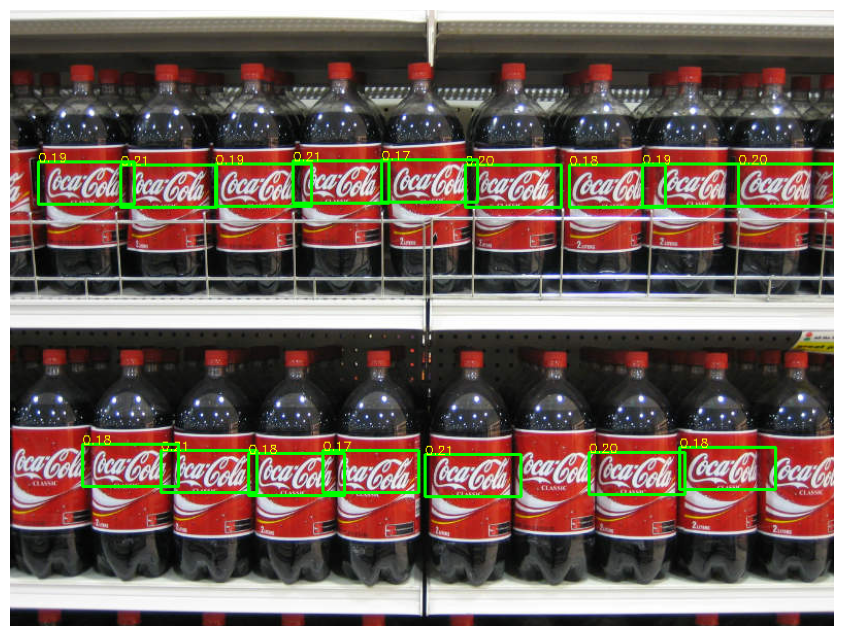

In [98]:

scales = np.linspace(0.2, .8, 20)
mejor_escala = None
best_confidence = -1

for s in scales:
    tmpl = cv.resize(template_canny, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
    th, tw = tmpl.shape
    if th > img_gray_canny.shape[0] or tw > img_gray_canny.shape[1]:
        continue
    
    res = cv.matchTemplate(img_gray_canny, tmpl, cv.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    
    if max_val > best_confidence:
        best_confidence = max_val
        mejor_escala = s


templ_mejor = cv.resize(template_canny, None, fx=mejor_escala, fy=mejor_escala, interpolation=cv.INTER_AREA)
th, tw = templ_mejor.shape

res_best = cv.matchTemplate(img_gray_canny, templ_mejor, cv.TM_CCOEFF_NORMED)

threshold = best_confidence * 0.77  

y_coords, x_coords = np.where(res_best >= threshold)
detections_all = []

for x, y in zip(x_coords, y_coords):
    confidence = res_best[y, x]
    detections_all.append((confidence, (x, y), tw, th, mejor_escala))

detections_nms = nms(detections_all, tresh=0.6)

img_draw = img_rgb.copy()
for max_val, max_loc, tw, th, s_val in detections_nms:
    top_left = max_loc
    bottom_right = (top_left[0] + tw, top_left[1] + th)
    cv.rectangle(img_draw, top_left, bottom_right, (0, 255, 0), 2)
    cv.putText(img_draw, f"{max_val:.2f}", top_left, cv.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

plt.figure(figsize=(14, 8))
plt.imshow(img_draw)
plt.axis('off')
plt.show()


### Punto 3

✓ Cargada: COCA-COLA-LOGO.jpg
✓ Cargada: coca_logo_1.png
✓ Cargada: coca_logo_2.png
✓ Cargada: coca_multi.png
✓ Cargada: coca_retro_1.png
✓ Cargada: coca_retro_2.png
✓ Cargada: logo_1.png

Total de imágenes cargadas: 7

COCA-COLA-LOGO.jpg: 41 detecciones (escala: 0.20)
coca_logo_1.png: 1 detecciones (escala: 0.40)
coca_logo_2.png: 7 detecciones (escala: 0.20)
coca_multi.png: 23 detecciones (escala: 0.20)
coca_retro_1.png: 21 detecciones (escala: 0.20)
coca_retro_2.png: 1 detecciones (escala: 0.40)
logo_1.png: 2 detecciones (escala: 0.20)


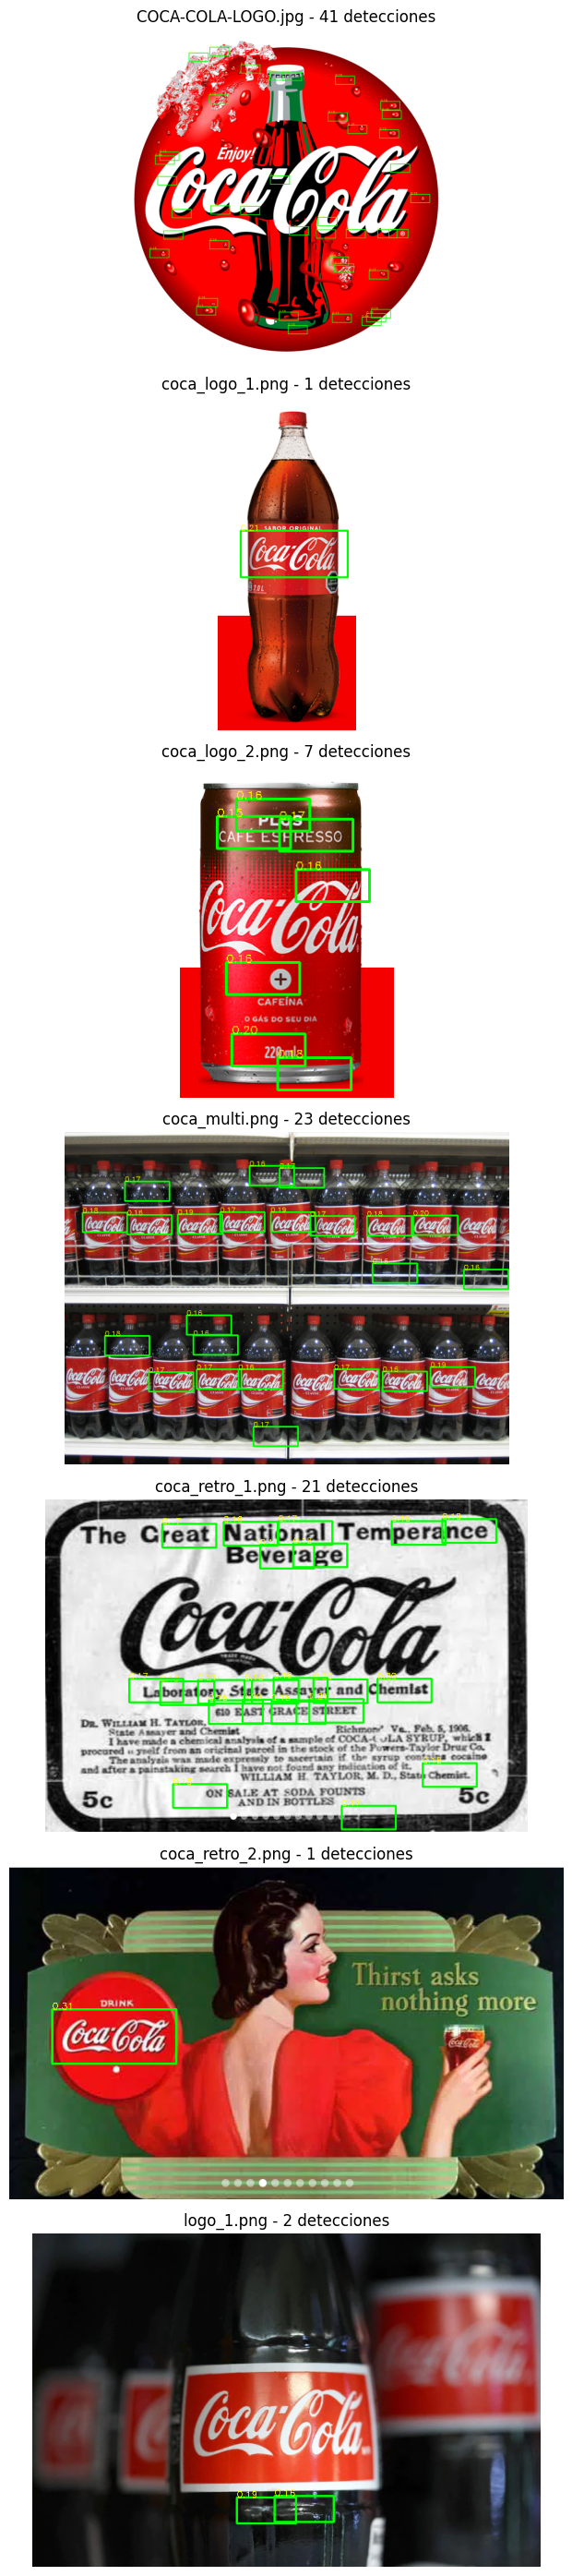


RESUMEN DE DETECCIONES
COCA-COLA-LOGO.jpg: 41 detecciones
coca_logo_1.png: 1 detecciones
coca_logo_2.png: 7 detecciones
coca_multi.png: 23 detecciones
coca_retro_1.png: 21 detecciones
coca_retro_2.png: 1 detecciones
logo_1.png: 2 detecciones


In [99]:
import os
from pathlib import Path

# Ruta de la carpeta de imágenes
images_dir = 'images'
image_extensions = {'.png', '.jpg'}

# Leer todas las imágenes
imagenes = []
for filename in os.listdir(images_dir):
    if Path(filename).suffix.lower() in image_extensions:
        img_path = os.path.join(images_dir, filename)
        img = cv.imread(img_path)
        if img is not None:
            imagenes.append({'filename': filename, 'image': img})
            print(f"✓ Cargada: {filename}")

print(f"\nTotal de imágenes cargadas: {len(imagenes)}\n")

# Aplicar algoritmo de detección a cada imagen
resultados = []

for img_data in imagenes:
    filename = img_data['filename']
    img = img_data['image']
    
    # Preprocesamiento
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gb = cv.GaussianBlur(img_gray, (5, 5), 0)
    img_gray_canny = cv.Canny(img_gb, 50, 200)
    
    # Encontrar mejor escala
    scales = np.linspace(0.2, 4, 20)
    mejor_escala = None
    best_confidence = -1
    
    for s in scales:
        tmpl = cv.resize(template_canny, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
        th, tw = tmpl.shape
        if th > img_gray_canny.shape[0] or tw > img_gray_canny.shape[1]:
            continue
        
        res = cv.matchTemplate(img_gray_canny, tmpl, cv.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        if max_val > best_confidence:
            best_confidence = max_val
            mejor_escala = s
    
    # Template matching en mejor escala
    tmpl_mejor = cv.resize(template_canny, None, fx=mejor_escala, fy=mejor_escala, 
                           interpolation=cv.INTER_AREA)
    th, tw = tmpl_mejor.shape
    res_best = cv.matchTemplate(img_gray_canny, tmpl_mejor, cv.TM_CCOEFF_NORMED)
    
    threshold = best_confidence * 0.77
    y_coords, x_coords = np.where(res_best >= threshold)
    detections_all = []
    
    for x, y in zip(x_coords, y_coords):
        confidence = res_best[y, x]
        detections_all.append((confidence, (x, y), tw, th, mejor_escala))
    
    # Aplicar NMS
    detections_nms = nms(detections_all, tresh=0.3)
    
    # Guardar resultado
    resultados.append({
        'filename': filename,
        'detections': detections_nms,
        'count': len(detections_nms),
        'best_scale': mejor_escala,
        'best_confidence': best_confidence,
        'image_rgb': img_rgb
    })
    
    print(f"{filename}: {len(detections_nms)} detecciones (escala: {mejor_escala:.2f})")

# Visualizar resultados
fig, axes = plt.subplots(len(resultados), 1, figsize=(14, 4 * len(resultados)))
if len(resultados) == 1:
    axes = [axes]

for idx, resultado in enumerate(resultados):
    img_draw = resultado['image_rgb'].copy()
    
    for max_val, max_loc, tw, th, s_val in resultado['detections']:
        top_left = max_loc
        bottom_right = (top_left[0] + tw, top_left[1] + th)
        cv.rectangle(img_draw, top_left, bottom_right, (0, 255, 0), 2)
        cv.putText(img_draw, f"{max_val:.2f}", top_left, cv.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
    
    axes[idx].imshow(img_draw)
    axes[idx].set_title(f"{resultado['filename']} - {resultado['count']} detecciones")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Resumen general
print("\n" + "="*60)
print("RESUMEN DE DETECCIONES")
print("="*60)
for res in resultados:
    print(f"{res['filename']}: {res['count']} detecciones")
print("="*60)